# Admission Mortality - Inpatient and ICU

In [5]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import polars as pl

from ethos.constants import PROJECT_ROOT
from ethos.constants import SpecialToken as ST
from ethos.inference.constants import Reason, Task
from ethos.metrics import compute_and_print_metrics, preprocess_inference_results
from ethos.utils import get_mimic_hf_patients, get_mimic_sepsis_icu_stays

# Requires original MIMIC-IV 2.2 dataset that we do not provide
mimic_sepsis = get_mimic_sepsis_icu_stays()
# heart_failure_cohort = get_mimic_hf_patients(PROJECT_ROOT / "data/mimic-2.2")
from pathlib import Path
heart_failure_cohort = get_mimic_hf_patients(Path("/data/raw_data/mimic/files/mimiciv/3.1/"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MIMIC

In [9]:
# results_dir = PROJECT_ROOT / "results"
results_dir = Path("/data/models/zj2398/ethos/results")
hosp_mort_result_dir = results_dir / Task.HOSPITAL_MORTALITY

print(hosp_mort_result_dir)
def preprocess_hosp_mortality_results(input_dir) -> pl.DataFrame:
    return preprocess_inference_results(
        input_dir,
        actual_expr=pl.col("actual") == ST.DEATH,
        expected_expr=pl.col("expected") == ST.DEATH,
        filter_ambiguous=(
            pl.col("actual").is_in([ST.DEATH, ST.DISCHARGE])
            & (pl.col("stop_reason") == Reason.GOT_TOKEN)
        ),
    )

/data/models/zj2398/ethos/results/hospital_mortality


2026-02-05 18:03:42.703 | WARNING  | ethos.metrics:preprocess_inference_results:311 - Dropped 7 results due to stop reason: key_error.


/home/zj2398@mc.cumc.columbia.edu/ethos-ares/src/ethos/metrics.py:153: RankWarning: Polyfit may be poorly conditioned
  f = np.poly1d(np.polyfit(lattice_idx[1:-1], thresholds[1:-1], 3))
/home/zj2398@mc.cumc.columbia.edu/ethos-ares/src/ethos/metrics.py:172: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  precision_values = np.divide(tpr_values * positives, denominator, where=more_than_zero)


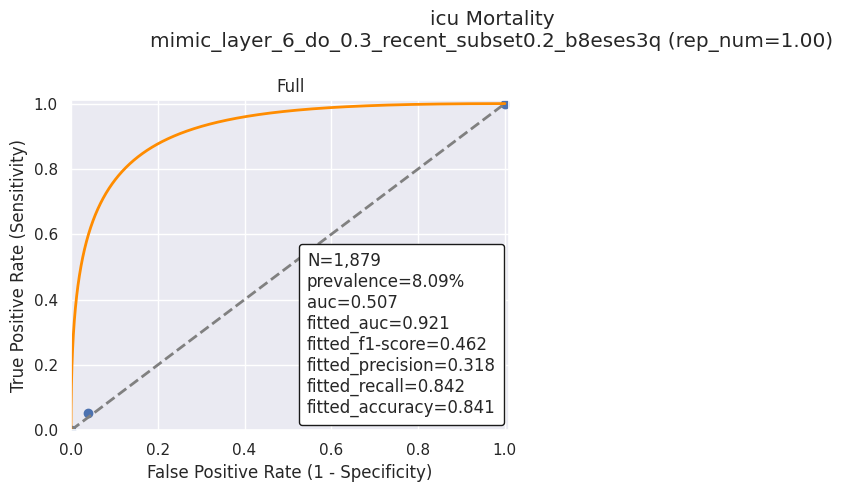

In [13]:
def preprocess_icu_mortality_results(input_dir) -> pl.DataFrame:
    return preprocess_inference_results(
        input_dir,
        actual_expr=pl.col("actual") == ST.DEATH,
        expected_expr=pl.col("expected") == ST.DEATH,
        # filter_ambiguous=(
        #     pl.col("actual").is_in([ST.DEATH, ST.DISCHARGE])
        #     & (pl.col("stop_reason") == Reason.GOT_TOKEN)
        # ),
    )

results_dir = Path("/data/models/zj2398/ethos/results")
icu_mort_result_dir = results_dir / Task.ICU_MORTALITY
icu_mortality_results = []
for result_fp in icu_mort_result_dir.iterdir():
    df = preprocess_icu_mortality_results(result_fp)
    rep_num = df["counts"].mean()
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"icu Mortality\n{result_fp.name} (rep_num={rep_num:.2f})")
    plt.subplot(1, 2, 1)
    # print(df["expected"])
    # print(df["actual"])
    res_full = compute_and_print_metrics(df["expected"], df["actual"], "Full")

    # plt.subplot(1, 2, 2)

    icu_mortality_results.append(
        {
            "name": result_fp.name,
            "auc": res_full["fitted_auc"],
            "rep_num": rep_num,
        }
    )
    plt.tight_layout()
    plt.show()
icu_mortality_results = pl.from_dicts(icu_mortality_results).sort("auc", descending=True)

## Hospital Mortality

In [8]:
hospital_mortality_results = []
for result_fp in hosp_mort_result_dir.iterdir():
    df = preprocess_hosp_mortality_results(result_fp)
    rep_num = df["counts"].mean()
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Hospital Mortality\n{result_fp.name} (rep_num={rep_num:.2f})")
    plt.subplot(1, 2, 1)
    res_full = compute_and_print_metrics(df["expected"], df["actual"], "Full")

    plt.subplot(1, 2, 2)
    hf_df = df.filter(pl.col("patient_id").is_in(heart_failure_cohort))
    res_hf = compute_and_print_metrics(hf_df["expected"], hf_df["actual"], "HF patients")

    hospital_mortality_results.append(
        {
            "name": result_fp.name,
            "auc": res_full["fitted_auc"],
            "auc_hf": res_hf["fitted_auc"],
            "rep_num": rep_num,
        }
    )
    plt.tight_layout()
    plt.show()
hospital_mortality_results = pl.from_dicts(hospital_mortality_results).sort("auc", descending=True)

FileNotFoundError: [Errno 2] No such file or directory: '/data/models/zj2398/ethos/results/hospital_mortality'

In [ ]:
hospital_mortality_results